# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
 # define your regions here
presel = {
        "mu": {
            "mll": "mll_loose>60",
            "mll": "mll_loose<120",
        },
        "ele": {
            "mll": "mll_loose>60",
            "mll": "mll_loose<120",          
        },
}


channels = ["ele"]
samples = [
    "Data",
    "DYJets",
]

years = ["2016", "2016APV", "2017", "2018"]
# years = ["2017"]

samples_dir = {

    # new jobs
#     "2018": "../eos/June19_zll_2018",
#     "2017": "../eos/June19_zll_2017",
#     "2016": "../eos/June19_zll_2016",
#     "2016APV": "../eos/June19_zll_2016APV",
    
    # below are the jobs that allow for the PR to be derived
    "2018": "../eos/June21_zll_2018",
    "2017": "../eos/June21_zll_2017",
    "2016": "../eos/June21_zll_2016",
    "2016APV": "../eos/June21_zll_2016APV",
}

In [6]:
from make_stacked_hists import make_events_dict

events_dict = {}
for year in years:
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, add_THWW=False)
    events_dict = {**events_dict, **out}

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying mll selection on 368 events
INFO:root:Will fill the Data dataframe with the remaining 351 events
INFO:root:tot event weight 351.0 

INFO:root:Finding SingleElectron_Run2016H samples and should combine them under Data
INFO:root:Applying mll selection on 395 events
INFO:root:Will fill the Data dataframe with the remaining 384 events
INFO:root:tot event weight 384.0 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under DYJets
INFO:root:Applying mll selection on 11291 events
INFO:root:Will fill the DYJets dataframe with the remaining 9816 events
INFO:root:tot event weight 3.1928982181721164 

INFO:root:Finding SingleElectron_Run2016F samples and should combine them under Data
INFO:root:Applying mll selection on 23 events
INFO:root:Will fill the Data dataframe with the remaining 23 events
INFO:root:tot event weight 23.0 

INFO:root:Finding DYJetsToLL_L

INFO:root:Will fill the DYJets dataframe with the remaining 12015 events
INFO:root:tot event weight 832.4409671038563 

INFO:root:Finding EGamma_Run2018A samples and should combine them under Data
INFO:root:Applying mll selection on 605 events
INFO:root:Will fill the Data dataframe with the remaining 583 events
INFO:root:tot event weight 583.0 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-50To100 samples and should combine them under DYJets
INFO:root:Applying mll selection on 218 events
INFO:root:Will fill the DYJets dataframe with the remaining 178 events
INFO:root:tot event weight 39.494572844925244 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under DYJets
INFO:root:Applying mll selection on 225027 events
INFO:root:Will fill the DYJets dataframe with the remaining 223268 events
INFO:root:tot event weight 1858.2271574968488 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:Applying mll sele

In [7]:
events_dict["2017"]["ele"].keys()

dict_keys(['DYJets', 'Data'])

# Stacked hists

In [8]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [9]:
for key in events_dict["2017"]["ele"]["Data"].keys():
    print(key)

N_tight_lep
N_loose_lep
tight_lep1_pt
tight_lep1_eta
tight_lep2_pt
tight_lep2_eta
mll_tight
loose_lep1_pt
loose_lep1_eta
loose_lep2_pt
loose_lep2_eta
mll_loose
met_pt
NumFatjets
lep_fj_dr
fj_pt
fj_eta
fj_phi
mT_tight1
mT_loose1
event_weight


In [10]:
vars_to_plot = [
#     "N_tight_lep",
#     "N_loose_lep",
    "tight_lep1_pt",
    "tight_lep1_eta",
#     "tight_lep2_pt",
#     "tight_lep2_eta",
#     "mll_tight",
    "mll_loose",    
#     "loose_lep1_pt",
#     "loose_lep1_eta",
#     "loose_lep2_pt",
#     "loose_lep2_eta",
#     "met_pt",
#     "mT_tight1",
]

samples_to_plot = [
    "Data",
    "DYJets",
]

In [11]:
import utils

axis_dict = {
    "loose_lep1_pt": hist2.axis.Regular(40, 38, 400, name="var", label=r"Loose electron $p_T$ [GeV]", overflow=True),    
    "loose_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Loose electron |$\eta$|", overflow=True),    

    "tight_lep1_pt": hist2.axis.Regular(30, 38, 200, name="var", label=r"Tight electron $p_T$ [GeV]", overflow=True),    
    "tight_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Tight electron |$\eta$|", overflow=True),

    "met_pt": hist2.axis.Regular(40, 0, 20, name="var", label=r"MET [GeV]", overflow=True),

    "mll_tight": hist2.axis.Regular(50, 60, 120, name="var", label=r"m$\ell$$\ell$", overflow=True),
    "mll_loose": hist2.axis.Regular(50, 60, 120, name="var", label=r"m$\ell$$\ell$", overflow=True),

}

years = [
    "2016", 
    "2016APV", 
    "2017", 
    "2018",
]

ch = "ele"

# fill histograms
hists = {}

for var in vars_to_plot:

    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        axis_dict[var],
        storage=hist2.storage.Weight(),            
    )        

    for year in years:    
        for sample in samples_to_plot:
            df = events_dict[year][ch][sample]

            x = df[var]
            w = df["event_weight"]

            msk = (w<100) & (w>-100)
            x = x[msk]
            w = w[msk]
            
            hists[var].fill(
                samples=sample,
                var=x,
                weight=w,
            )     

for var in vars_to_plot:
    fix_neg_yields(hists[var])

Will plot tight_lep1_pt histogram
Will plot tight_lep1_eta histogram
Will plot mll_loose histogram


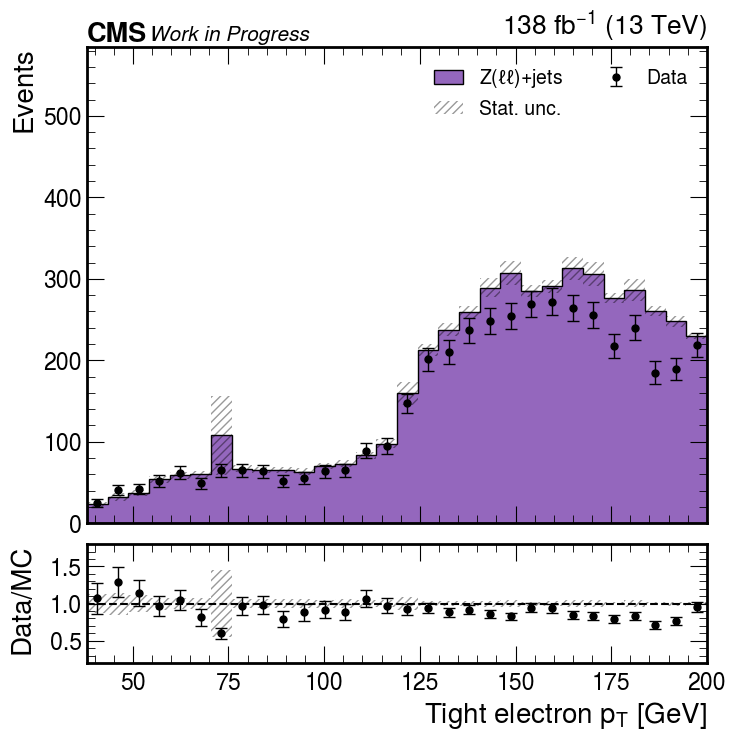

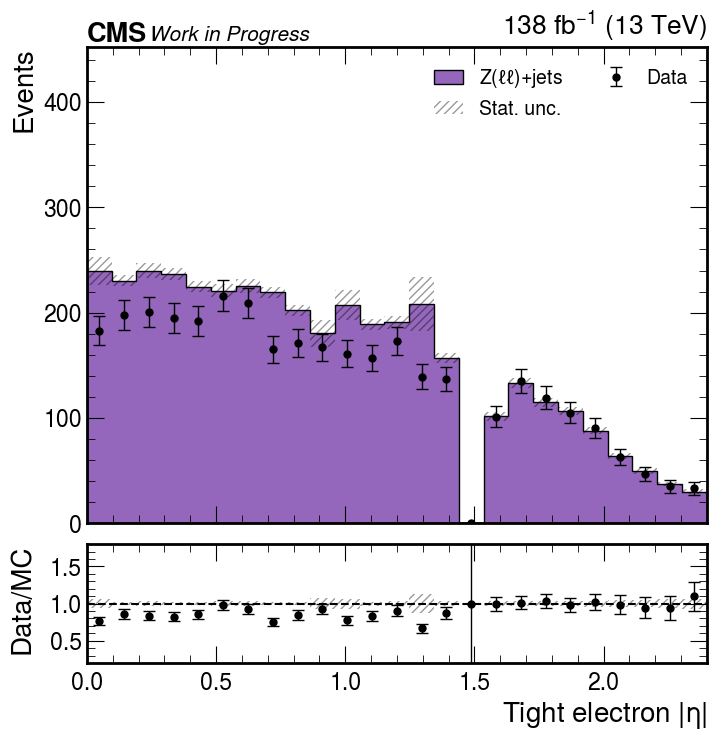

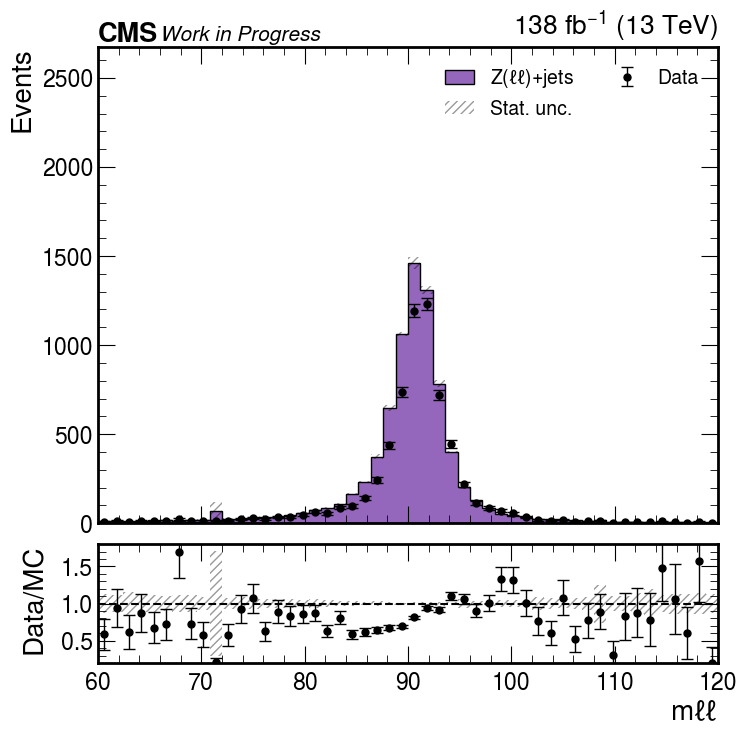

In [12]:
plt.rcParams.update({"font.size": 20})
add_data = True
add_soverb = False
    
from utils import plot_hists as plot_hists

if len(years)>1:
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/prompt/{ch}_Run2"
else:
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/prompt/{ch}_{year}"

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=1,
            outpath=PATH,
#             text_=text_,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=False,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )

# Deriving the SF

In [44]:
years = ["2016", "2016APV", "2017", "2018"]
ch = "ele"
SF, SF_unc = {}, {}

for year in years:    
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(20, 60, 120, name="var", label=r"mll", overflow=True),
        storage=hist2.storage.Weight(),            
    )        

    for sample in samples_to_plot:
        df = events_dict[year][ch][sample]

        x = df["mll_tight"]
        w = df["event_weight"]

        # Apply weight cuts
        mask = (w < 100) & (w > -100)
        x = x[mask]
        w = w[mask]

        h.fill(
            samples=sample,
            var=x,
            weight=w,
        )     

    # Calculate the scale factor for the current year
    data = h[{"samples": "Data"}].sum().value
    ewk = h[{"samples": "DYJets"}].sum().value

    SF[year] = data / ewk
    SF_unc[year] = SF[year] * np.sqrt( (np.sqrt(data)/data)**2 + (np.sqrt(ewk)/ewk)**2 )

# Print the dictionary in a format suitable for copy-pasting
print("EWK_SF = {")
print('   "EWK_SF_Nominal": {')
for year in SF:
    print(f'        "{year}": {SF[year]:.3f},')
print("    },")

print('   "EWK_SF_Up": {')
for year in SF:
    print(f'        "{year}": {SF[year]+SF_unc[year]:.3f},')
print("    },")


print('   "EWK_SF_Down": {')
for year in SF:
    print(f'        "{year}": {SF[year]-SF_unc[year]:.3f},')
print("    },")


print("}")

EWK_SF = {
   "EWK_SF_Nominal": {
        "2016": 0.700,
        "2016APV": 0.743,
        "2017": 0.880,
        "2018": 0.796,
    },
   "EWK_SF_Up": {
        "2016": 0.738,
        "2016APV": 0.780,
        "2017": 0.908,
        "2018": 0.820,
    },
   "EWK_SF_Down": {
        "2016": 0.661,
        "2016APV": 0.706,
        "2017": 0.852,
        "2018": 0.772,
    },
}


# Deriving the PR

In [30]:
years = ["2016", "2016APV", "2017", "2018"]
ch = "ele"
# sample = "DYJets"
sample = "Data"

PR = {}

for year in years:    
    df = events_dict[year][ch][sample]
        
    num = (df["N_tight_lep"] == 2).sum()    
    den = (df["N_loose_lep"] == 2).sum()    

    pr = num / den
    PR[year] = pr

# Print the dictionary in a format suitable for copy-pasting
print("PR = {")
for year in PR:
    print(f'    "{year}": {PR[year]:.3f},')
print("}")


PR = {
    "2016": 0.774,
    "2016APV": 0.731,
    "2017": 0.796,
    "2018": 0.788,
}


In [31]:
(df["N_loose_lep"]==2).sum()

2630

In [32]:
(df["N_tight_lep"]==2).sum()

2073